# Model WL Profiles (different redshift inputs)
## Model profiles using different type of source redshift information as input

In this example we model lensing profiles by giving as input either : 
- discrete source redshifts, 
- a redshift distribution function,
- the value of the mean beta parameters : 
$\langle \beta_s \rangle = \left\langle \frac{D_{LS}}{D_S}\frac{D_\infty}{D_{L,\infty}}\right\rangle$ ,
$\langle \beta_s^2 \rangle = \left\langle \left(\frac{D_{LS}}{D_S}\frac{D_\infty}{D_{L,\infty}}\right)^2 \right\rangle$

In [24]:
import warnings

warnings.filterwarnings("ignore", message=".*(!).*")
import os

## Uncomment the following line if you want to use a specific modeling backend among 'ct' (cluster-toolkit), 'ccl' (CCL) or 'nc' (Numcosmo). Default is 'ccl'
#os.environ['CLMM_MODELING_BACKEND'] = 'nc'

In [25]:
import clmm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math

%matplotlib inline

In [26]:
import matplotlib

matplotlib.rcParams.update({"font.size": 16})

Make sure we know which version we're using

In [27]:
clmm.__version__

'1.8.1'

## Import mock data module and setup the configuration 

In [28]:
from clmm.support import mock_data as mock
from clmm import Cosmology
from clmm.redshift.distributions import *

Mock data generation requires a defined cosmology

In [29]:
mock_cosmo = Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

Mock data generation requires some cluster information

In [30]:
cosmo = mock_cosmo

# cluster properties from https://arxiv.org/pdf/1611.03866.pdf
cluster_id = "SPT-CL J0000−5748"
cluster_m = 4.56e14  # M500,c
cluster_z = 0.702
cluster_ra = 0.2499
cluster_dec = -57.8064
concentration = 5  # (arbitrary value, not from the paper)

# source redshift distribution properties
cluster_beta_s_mean = 0.466
cluster_beta_s2_mean = 0.243
ngal_density = (
    26.0 * 100
)  # density of source galaxies per arcmin^2 # (arbitrary value, not from the paper)
model_z_distrib_dict = {"func": desc_srd, "name": "desc_srd"}
delta_z_cut = 0.1
zsrc_min = cluster_z + delta_z_cut
zsrc_max = 3.0

## 1 - Defining the different inputs for the source redshifts

### Discrete redshifts

#### Generate the mock source catalog

The CLMM mock data generation will provide, among other things, a redshift value for each background galaxy that is draw from the redshift distribution given by `model_z_distrib_dict`.

In [31]:
np.random.seed(0)
source_catalog = mock.generate_galaxy_catalog(
    cluster_m,
    cluster_z,
    concentration,
    cosmo,
    model_z_distrib_dict["name"],
    delta_so=500,
    massdef="critical",
    zsrc_min=zsrc_min,
    zsrc_max=zsrc_max,
    ngal_density=ngal_density,
    cluster_ra=cluster_ra,
    cluster_dec=cluster_dec,
)

### Beta parameters
From this udnerlying redshift distribution, one may directly compute the average $\langle\beta_s\rangle$ and $\langle\beta_s^2\rangle$ quantities

In [32]:
beta_label = lambda beta: rf"\langle\beta_s\rangle = {beta:.3f}"
beta_sq_label = lambda beta_sq: rf"\langle\beta_s^2\rangle = {beta_sq:.3f}"

In [33]:
z_inf = 1000

beta_s_mean = clmm.utils.beta_lens.compute_beta_s_mean_from_distribution(
    cluster_z,
    z_inf,
    cosmo,
    zmax=zsrc_max,
    delta_z_cut=delta_z_cut,
    zmin=None,
    z_distrib_func=model_z_distrib_dict["func"],
)
beta_s_square_mean = clmm.utils.beta_lens.compute_beta_s_square_mean_from_distribution(
    cluster_z,
    z_inf,
    cosmo,
    zmax=zsrc_max,
    delta_z_cut=delta_z_cut,
    zmin=None,
    z_distrib_func=model_z_distrib_dict["func"],
)

display(Math(beta_label(beta_s_mean)))
display(Math(beta_sq_label(beta_s_square_mean)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Visualisation

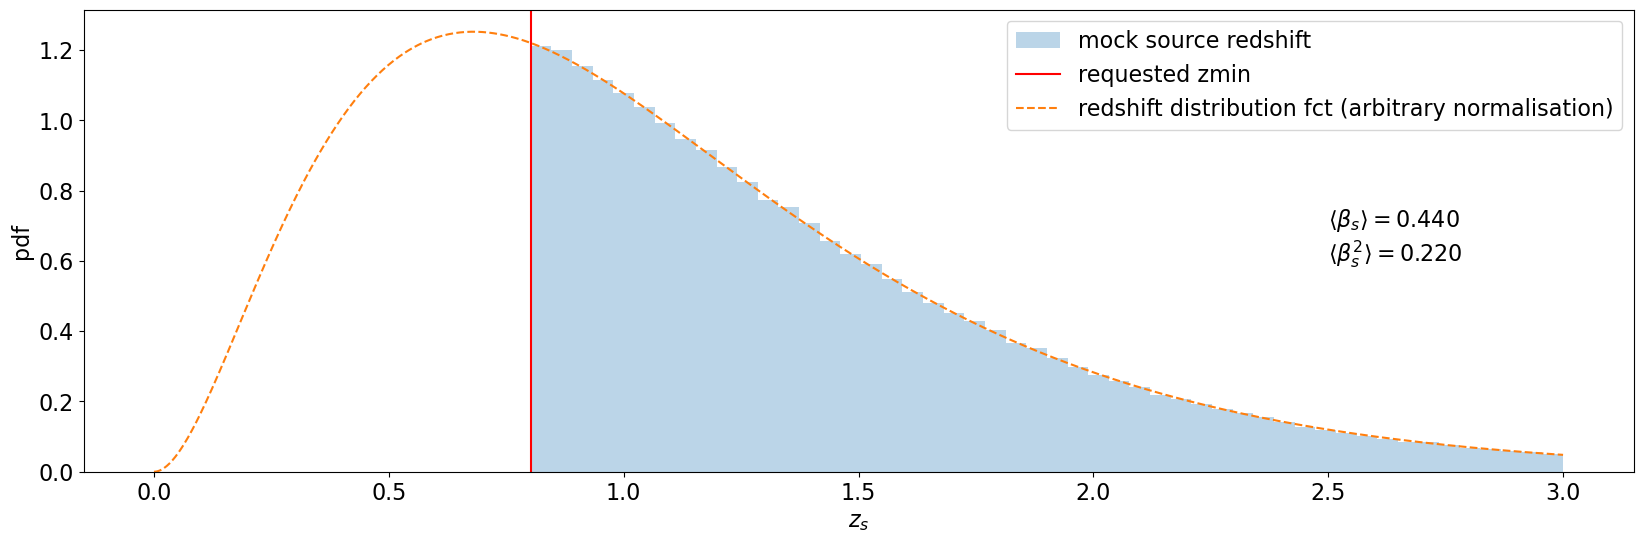

In [34]:
z = np.linspace(0, zsrc_max, 1000)

matplotlib.rcParams.update({"figure.figsize": (20, 6)})

plt.hist(source_catalog["z"], bins=50, alpha=0.3, density=True, label="mock source redshift")
plt.axvline(zsrc_min, color="red", label="requested zmin")
plt.text(2.5, 0.6, f"${beta_label(beta_s_mean)}$\n${beta_sq_label(beta_s_square_mean)}$")
# here we multiply by a constant for visualisation purposes
plt.plot(
    z,
    model_z_distrib_dict["func"](z) * 25,
    linestyle="dashed",
    label="redshift distribution fct (arbitrary normalisation)",
)
plt.xlabel("$z_s$")
plt.ylabel("pdf")
plt.legend()

Here we use a zmax=3 (different from default values) to highlight the importance of specifying the zmax when computing the modeling. 

## 2 - Compute models

Here we are computing the models for the tangential shear, reduced shear, convergence, magnification and magnification bias.

### Profile from mock data

First we compute the cluster profile based on the mock source catalog produced in the previous section.

In [35]:
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec, cluster_z, source_catalog)

In [36]:
gc_object.compute_tangential_and_cross_components()

(array([0.00218744, 0.00176588, 0.00042673, ..., 0.00224765, 0.00186142,
        0.00032859]),
 array([0.00898515, 0.01455188, 0.086497  , ..., 0.00915508, 0.0164856 ,
        0.13692621]),
 array([-4.77048956e-18, -7.80625564e-18, -3.46944695e-17, ...,
        -5.20417043e-18, -1.12757026e-17, -6.93889390e-17]))

In [37]:
gc_object.make_radial_profile("Mpc", bins=10, cosmo=cosmo)
pass

### Different ways of modeling the reduced shear

In [38]:
# define radius
rr = np.logspace(np.log10(0.2), np.log10(5), 10)

#### **Case 1 : Discrete redshift and exact formula**

In case we know the discrete source redshift, we can compute the reduced shear for each source galaxy and take the average at a given radius.

This may take a bit of time, depending on the size of source redshift catalog and number of radius points.

In [39]:
%%time
# in case we know the discrete source redshift, we can compute the reduced shear for each source galaxy
# and take the average at a given radius.
gt_discrete = np.array(
    [
        np.mean(
            clmm.theory.compute_reduced_tangential_shear(
                _r,
                cluster_m,
                concentration,
                cluster_z,
                source_catalog["z"],
                cosmo,
                delta_mdef=500,
                massdef="critical",
                z_src_info="discrete",
                approx=None,
            )
        )
        for _r in rr
    ]
)

CPU times: user 2.16 s, sys: 169 ms, total: 2.33 s
Wall time: 2.33 s


#### Case 2 : Redshift distribution and exact formula

If we don't know the exact source redshift but we know the source mean redshift distribution function, we can give it as input.

In this case, we are integrating over the distribution function so it may be quite slow.

In [40]:
%%time
gt_distribution_no_approx = clmm.theory.compute_reduced_tangential_shear(
    rr,
    cluster_m,
    concentration,
    cluster_z,
    model_z_distrib_dict["func"],
    cosmo,
    delta_mdef=500,
    massdef="critical",
    z_src_info="distribution",
    approx=None,
)

CPU times: user 553 ms, sys: 6.02 ms, total: 559 ms
Wall time: 558 ms


#### Cases 3 : Mean lensing efficiencies and approximation

Finally, we can also model the reduced shear if the only information we have about the source redshift distribution is through the mean lensing efficiency parameters $\langle\beta_s\rangle$ and $\langle\beta_s^2\rangle$. \
In this case, we need to use an approximation for the formula. This is the fastest approach.

In [41]:
%%time
gt_beta_1 = clmm.theory.compute_reduced_tangential_shear(
    rr,
    cluster_m,
    concentration,
    cluster_z,
    [beta_s_mean, beta_s_square_mean],
    cosmo,
    delta_mdef=500,
    massdef="critical",
    z_src_info="beta",
    approx="order1"
)

CPU times: user 1.26 ms, sys: 905 µs, total: 2.16 ms
Wall time: 1.73 ms


In [42]:
%%time
gt_beta_2 = clmm.theory.compute_reduced_tangential_shear(
    rr,
    cluster_m,
    concentration,
    cluster_z,
    [beta_s_mean, beta_s_square_mean],
    cosmo,
    delta_mdef=500,
    massdef="critical",
    z_src_info="beta",
    approx="order2"
)

CPU times: user 1.17 ms, sys: 21 µs, total: 1.19 ms
Wall time: 1.12 ms


## 3 - Comparison of the three cases for the reduced tangnetial shear

In [43]:
def plot_cases(radius, base, others, ylabel=None, data=None):
    matplotlib.rcParams.update({"figure.figsize": (8, 8)})
    fig, axes = plt.subplots(2, sharex=True, height_ratios=[4, 1])

    if data is not None:
        axes[0].loglog(*data[:-1], **data[-1])

    axes[0].loglog(radius, *base[:-1], **base[-1])
    for case in others:
        axes[0].loglog(radius, *case[:-1], **case[-1])
        axes[1].plot(radius, 100 * (case[0] / base[0] - 1), *case[1:-1], **case[-1])

    axes[0].legend(fontsize=12)
    axes[0].set_ylabel(ylabel)
    axes[1].set_ylabel("%")
    axes[1].set_xlabel("radius [Mpc]")

    plt.subplots_adjust(hspace=0)
    for ax in axes:
        ax.minorticks_on()
        ax.grid(lw=0.5)
        ax.grid(which="minor", lw=0.2)

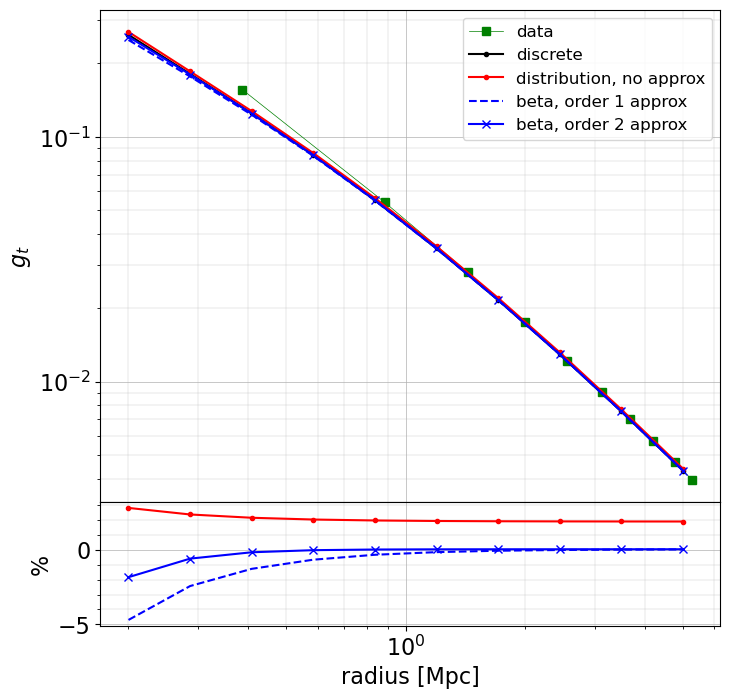

In [44]:
plot_cases(
    rr,
    base=(gt_discrete, "k.-", dict(label="discrete")),
    others=(
        (gt_distribution_no_approx, "r.-", dict(label="distribution, no approx")),
        (gt_beta_1, "b--", dict(label="beta, order 1 approx")),
        (gt_beta_2, "bx-", dict(label="beta, order 2 approx")),
    ),
    data=(gc_object.profile["radius"], gc_object.profile["gt"], "gs-", dict(label="data", lw=0.5)),
    ylabel="$g_t$",
)

All modeled profiles give similar results. They do not correspond to the profile computed from the data in the inner part, because of different ways of constructing the profiles (taking the average radial point and reduced shear value in a bin or computing the average expected reduced shear at a given radius).

The profiles computed using an approximation for the reduced shear formula are lower by a few percents, especially in the inner region. The profiles computed from a redshift distribution or a known source redshift differ at the subpercent level.

## 4- Modeling and plotting the other quantities

Here we will just compute models for cases 1, 2 and 3. For the shear and convergence there is no need for an approximated formula. 

In [45]:
gammat_discrete = np.array(
    [
        np.mean(
            clmm.theory.compute_tangential_shear(
                _r,
                cluster_m,
                concentration,
                cluster_z,
                source_catalog["z"],
                cosmo,
                delta_mdef=500,
                massdef="critical",
                z_src_info="discrete"
            )
        )
        for _r in rr
    ]
)

gammat_distribution = clmm.theory.compute_tangential_shear(
    rr,
    cluster_m,
    concentration,
    cluster_z,
    model_z_distrib_dict["func"],
    cosmo,
    delta_mdef=500,
    massdef="critical",
    z_src_info="distribution",
    validate_input=False
)

gammat_beta = clmm.theory.compute_tangential_shear(
    rr,
    cluster_m,
    concentration,
    cluster_z,
    [beta_s_mean, beta_s_square_mean],
    cosmo,
    delta_mdef=500,
    massdef="critical",
    z_src_info="beta"
)

UnboundLocalError: cannot access local variable 'gammat' where it is not associated with a value

In [ ]:
plot_cases(
    rr,
    base=(gammat_discrete, "k.-", dict(label="discrete")),
    others=(
        (gammat_distribution, "rx-", dict(label="distribution, no approx")),
        (gammat_beta, "b--", dict(label="beta, no approx")),
    ),
    ylabel="$\gamma_t$",
)

In [ ]:
kappa_discrete = np.array(
    [
        np.mean(
            clmm.theory.compute_convergence(
                _r,
                cluster_m,
                concentration,
                cluster_z,
                source_catalog["z"],
                cosmo,
                delta_mdef=500,
                massdef="critical",
                z_src_info="discrete",
            )
        )
        for _r in rr
    ]
)

kappa_distribution = clmm.theory.compute_convergence(
    rr,
    cluster_m,
    concentration,
    cluster_z,
    model_z_distrib_dict["func"],
    cosmo,
    delta_mdef=500,
    massdef="critical",
    z_src_info="distribution",
    beta_kwargs={"zmax": zsrc_max},
)

kappa_beta = clmm.theory.compute_convergence(
    rr,
    cluster_m,
    concentration,
    cluster_z,
    [beta_s_mean, beta_s_square_mean],
    cosmo,
    delta_mdef=500,
    massdef="critical",
    z_src_info="beta",
    beta_kwargs={"zmax": zsrc_max},
)

In [ ]:
plot_cases(
    rr,
    base=(kappa_discrete, "k.-", dict(label="discrete")),
    others=(
        (kappa_distribution, "rx-", dict(label="distribution, no approx")),
        (kappa_beta, "b--", dict(label="beta, no approx")),
    ),
    ylabel="$\kappa_t$",
)

In [ ]:
mu_discrete = np.array(
    [
        np.mean(
            clmm.theory.compute_magnification(
                _r,
                cluster_m,
                concentration,
                cluster_z,
                source_catalog["z"],
                cosmo,
                delta_mdef=500,
                massdef="critical",
                z_src_info="discrete",
            )
        )
        for _r in rr
    ]
)

mu_distribution = clmm.theory.compute_magnification(
    rr,
    cluster_m,
    concentration,
    cluster_z,
    model_z_distrib_dict["func"],
    cosmo,
    delta_mdef=500,
    massdef="critical",
    z_src_info="distribution",
    approx=None,
    beta_kwargs={"zmax": zsrc_max},
)

mu_beta_1 = clmm.theory.compute_magnification(
    rr,
    cluster_m,
    concentration,
    cluster_z,
    [beta_s_mean, beta_s_square_mean],
    cosmo,
    delta_mdef=500,
    massdef="critical",
    z_src_info="beta",
    approx="order1",
    beta_kwargs={"zmax": zsrc_max},
)

mu_beta_2 = clmm.theory.compute_magnification(
    rr,
    cluster_m,
    concentration,
    cluster_z,
    [beta_s_mean, beta_s_square_mean],
    cosmo,
    delta_mdef=500,
    massdef="critical",
    z_src_info="beta",
    approx="order2",
    beta_kwargs={"zmax": zsrc_max},
)

In [ ]:
plot_cases(
    rr,
    base=(mu_discrete, "k.-", dict(label="discrete")),
    others=(
        (mu_distribution, "rs-", dict(label="distribution, no approx")),
        (mu_beta_1, "bx-", dict(label="beta, order 1 approx")),
        (mu_beta_2, "b--", dict(label="beta, order 2 approx")),
    ),
    ylabel="$\mu_t$",
)

In [ ]:
alpha = 2.7  # arbitrary value for the slope of the number density

mu_bias_discrete = np.array(
    [
        np.mean(
            clmm.theory.compute_magnification_bias(
                _r,
                alpha,
                cluster_m,
                concentration,
                cluster_z,
                source_catalog["z"],
                cosmo,
                delta_mdef=500,
                massdef="critical",
                z_src_info="discrete",
            )
        )
        for _r in rr
    ]
)

mu_bias_distribution = clmm.theory.compute_magnification_bias(
    rr,
    alpha,
    cluster_m,
    concentration,
    cluster_z,
    model_z_distrib_dict["func"],
    cosmo,
    delta_mdef=500,
    massdef="critical",
    z_src_info="distribution",
    approx=None,
    beta_kwargs={"zmax": zsrc_max},
)

mu_bias_beta_1 = clmm.theory.compute_magnification_bias(
    rr,
    alpha,
    cluster_m,
    concentration,
    cluster_z,
    [beta_s_mean, beta_s_square_mean],
    cosmo,
    delta_mdef=500,
    massdef="critical",
    z_src_info="beta",
    approx="order1",
    beta_kwargs={"zmax": zsrc_max},
)

mu_bias_beta_2 = clmm.theory.compute_magnification_bias(
    rr,
    alpha,
    cluster_m,
    concentration,
    cluster_z,
    [beta_s_mean, beta_s_square_mean],
    cosmo,
    delta_mdef=500,
    massdef="critical",
    z_src_info="beta",
    approx="order2",
    beta_kwargs={"zmax": zsrc_max},
)

In [ ]:
plot_cases(
    rr,
    base=(mu_bias_discrete, "k.-", dict(label="discrete")),
    others=(
        (mu_bias_distribution, "rs-", dict(label="distribution, no approx")),
        (mu_bias_beta_1, "bx-", dict(label="beta, order 1 approx")),
        (mu_bias_beta_2, "b--", dict(label="beta, order 2 approx")),
    ),
    ylabel="$\delta_{\mu} + 1$",
)

When making approximation, there may be large differences (~few 10% level) in the inner regions (compare to when using the exact redshift of the sources), especially for magnification and magnification bias. However, these approaches are very fast to compute. The user as to chose the appropriate method depending on the use case.